In [1]:
# load packages
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import torch
import pickle
from torch.utils import data
import torch.nn as nn
import pandas as pd
import matplotlib.pyplot as plt

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
#load the dataset
df = pd.read_csv("dataset_normalized.csv")
total_rows = df.shape[0]

In [3]:
#splitting the dataset into train, validation and test set (70%, 10%, 20%)
val_end = int(total_rows*0.8)

labels = df["market_value"].values
df = df.drop(columns=["market_value"])

to_encode = df[['citizenship', 'current_club_id', 'position', 'sub_position', "competitions_id", "clubs_id"]]
#to_encode = df[['citizenship', 'current_club_id', 'position', 'sub_position']]
df = df.drop(['citizenship', 'current_club_id', 'position', 'sub_position', "competitions_id", "clubs_id"], axis=1)

test_to_encode = to_encode.iloc[val_end:].values

test_set = df.iloc[val_end:].values

y_test = labels[val_end:]

test_set_len = test_set.shape[0]

In [4]:
#input parameters
num_input_size = test_set.shape[1]
cat_input_size = to_encode.shape[1]
total_input_size = num_input_size + cat_input_size
voc_size_citizenship = len(to_encode['citizenship'].unique())
voc_size_current_club_id = len(to_encode['current_club_id'].unique())
voc_size_position = len(to_encode['position'].unique())
voc_size_sub_position = len(to_encode['sub_position'].unique())
voc_size_competitions = len(to_encode['competitions_id'].unique())+10
voc_size_clubs = len(to_encode['clubs_id'].unique())+65
#print them all
print("input size of numerical features is: {}".format(num_input_size))
print("input size of categorical features is: {}".format(cat_input_size))
print("voc size citizenship is: {}".format(voc_size_citizenship))
print("voc size current club id is: {}".format(voc_size_current_club_id))
print("voc size position is: {}".format(voc_size_position))
print("voc size sub position is: {}".format(voc_size_sub_position))
print("voc size competitions is: {}".format(voc_size_competitions))
print("voc size clubs is: {}".format(voc_size_clubs))

input size of numerical features is: 18
input size of categorical features is: 6
voc size citizenship is: 162
voc size current club id is: 391
voc size position is: 4
voc size sub position is: 16
voc size competitions is: 2727
voc size clubs is: 8119


In [5]:
class Dataset(data.Dataset):
    """Characterizes a dataset for PyTorch"""
    def __init__(self, x, to_encode, y, length):
        """Initialization"""

        self.length = length
        self.to_encode = torch.tensor(to_encode, device=device, dtype=torch.int32)
        self.y = torch.tensor(y, device=device, dtype=torch.float32)
        self.x = torch.tensor(x, device=device, dtype=torch.float32)

    def __len__(self):
        """Denotes the total number of samples"""
        return self.length

    def __getitem__(self, i):
        return self.x[i], self.to_encode[i] ,self.y[i]

dataset_test = Dataset(test_set, test_to_encode, y_test, test_set_len)
test_loader = torch.utils.data.DataLoader(dataset=dataset_test, batch_size=1, shuffle=False)

In [6]:
# Define a multilayer perceptron model class that inherits from nn.Module
class MLP(nn.Module):
  # Define the constructor method that takes the input size and the vocabulary sizes of four categorical features as arguments
  def __init__(self, num_input_size, voc_size_citizenship, voc_size_current_club_id, voc_size_position, voc_size_sub_position, voc_size_competitions, voc_size_clubs, hidden_size1, hidden_size2, hidden_size3, dropout, device):
    # Call the parent constructor
    super(MLP, self).__init__()

    # Compute the embedding sizes for each categorical feature using the fourth root of the vocabulary size
    emb_size_citizenship = int(voc_size_citizenship ** (1/4))
    emb_size_current_club_id = int(voc_size_current_club_id ** (1/4))
    emb_size_position = int(voc_size_position ** (1/4))
    emb_size_sub_position = int(voc_size_sub_position ** (1/4))
    emb_size_competitions = int(voc_size_competitions ** (1/4))
    emb_size_clubs = int(voc_size_clubs ** (1/4))

    # Define embedding layers for each categorical feature using the computed embedding sizes
    self.emb_cit = nn.Embedding(voc_size_citizenship, emb_size_citizenship, device=device)
    self.emb_club = nn.Embedding(voc_size_current_club_id, emb_size_current_club_id, device=device)
    self.emb_pos = nn.Embedding(voc_size_position, emb_size_position,  device=device)
    self.emb_sub_pos = nn.Embedding(voc_size_sub_position, emb_size_sub_position, device=device)
    self.emb_comp = nn.Embedding(voc_size_competitions, emb_size_competitions, device=device)
    self.emb_clubs = nn.Embedding(voc_size_clubs, emb_size_clubs, device=device)

    # Compute the total input size by adding the input size and the embedding sizes
    total_input_size = num_input_size + emb_size_citizenship + emb_size_current_club_id + emb_size_position + emb_size_sub_position + emb_size_competitions + emb_size_clubs

    # Define a linear layer that takes the total input size and outputs a single value
    self.fc1 = nn.Linear(total_input_size, hidden_size1, device=device)
    self.relu = nn.ReLU()
    self.batchnorm1 = nn.BatchNorm1d(hidden_size1, device=device)
    self.fc2 = nn.Linear(hidden_size1, hidden_size2, device=device)
    self.batchnorm2 = nn.BatchNorm1d(hidden_size2, device=device)
    self.fc3 = nn.Linear(hidden_size2, hidden_size3, device=device)
    self.batchnorm3 = nn.BatchNorm1d(hidden_size3, device=device)
    self.fc4 = nn.Linear(hidden_size3, 1, device=device)
    self.dropout = nn.Dropout(dropout)

  # Define the forward method that takes the numerical input and the categorical features to encode as arguments
  def forward(self, x, to_encode):
    # x: a tensor of shape (batch_size, input_size) containing the numerical features
    # to_encode: a tensor of shape (batch_size, 4) containing the values of the categorical features

    # Get the embeddings for each categorical feature using the corresponding embedding layer and indexing by the feature values
    cit_emb = self.emb_cit(to_encode[:, 0])

    club_emb = self.emb_club(to_encode[:, 1])

    pos_emb = self.emb_pos(to_encode[:, 2])

    sub_pos_emb = self.emb_sub_pos(to_encode[:, 3])

    comp_emb = self.emb_comp(to_encode[:, 4])

    clubs_emb = self.emb_clubs(to_encode[:, 5])

    # Concatenate the numerical input and the embeddings along the second dimension
    x = torch.cat((x, cit_emb, club_emb, pos_emb, sub_pos_emb, comp_emb, clubs_emb), dim=1)

    # Apply the linear layers, dropout and batchnorm to get the output
    x = self.fc1(x)
    x = self.dropout(x)
    x = self.batchnorm1(x)
    x = self.relu(x)

    x = self.fc2(x)
    x = self.dropout(x)
    x = self.batchnorm2(x)
    x = self.relu(x)

    x = self.fc3(x)
    x = self.dropout(x)
    x = self.batchnorm3(x)
    x = self.relu(x)

    output = self.fc4(x)

    # Return the output
    return output.flatten()

In [7]:
# Define a linear regression model class that inherits from nn.Module
class LinearRegression(nn.Module):
  # Define the constructor method that takes the input size and the vocabulary sizes of four categorical features as arguments
  def __init__(self, num_input_size, voc_size_citizenship, voc_size_current_club_id, voc_size_position, voc_size_sub_position, voc_size_competitions, voc_size_clubs, device):
    # Call the parent constructor
    super(LinearRegression, self).__init__()

    # Compute the embedding sizes for each categorical feature using the fourth root of the vocabulary size
    emb_size_citizenship = int(voc_size_citizenship ** (1/4))
    emb_size_current_club_id = int(voc_size_current_club_id ** (1/4))
    emb_size_position = int(voc_size_position ** (1/4))
    emb_size_sub_position = int(voc_size_sub_position ** (1/4))
    emb_size_competitions = int(voc_size_competitions ** (1/4))
    emb_size_clubs = int(voc_size_clubs ** (1/4))

    # Define embedding layers for each categorical feature using the computed embedding sizes
    self.emb_cit = nn.Embedding(voc_size_citizenship, emb_size_citizenship, device=device)
    self.emb_club = nn.Embedding(voc_size_current_club_id, emb_size_current_club_id, device=device)
    self.emb_pos = nn.Embedding(voc_size_position, emb_size_position,  device=device)
    self.emb_sub_pos = nn.Embedding(voc_size_sub_position, emb_size_sub_position, device=device)
    self.emb_comp = nn.Embedding(voc_size_competitions, emb_size_competitions, device=device)
    self.emb_clubs = nn.Embedding(voc_size_clubs, emb_size_clubs, device=device)

    # Compute the total input size by adding the input size and the embedding sizes
    total_input_size = num_input_size + emb_size_citizenship + emb_size_current_club_id + emb_size_position + emb_size_sub_position + emb_size_competitions + emb_size_clubs

    # Define a linear layer that takes the total input size and outputs a single value
    self.fc1 = nn.Linear(total_input_size, 1, device=device)

  # Define the forward method that takes the numerical input and the categorical features to encode as arguments
  def forward(self, x, to_encode):
    # x: a tensor of shape (batch_size, num_input_size) containing the numerical features
    # to_encode: a tensor of shape (batch_size, 4) containing the values of the categorical features

    # Get the embeddings for each categorical feature using the corresponding embedding layer and indexing by the feature values
    cit_emb = self.emb_cit(to_encode[:, 0])

    club_emb = self.emb_club(to_encode[:, 1])

    pos_emb = self.emb_pos(to_encode[:, 2])

    sub_pos_emb = self.emb_sub_pos(to_encode[:, 3])

    comp_emb = self.emb_comp(to_encode[:, 4])

    clubs_emb = self.emb_clubs(to_encode[:, 5])

    # Concatenate the numerical input and the embeddings along the second dimension
    x = torch.cat((x, cit_emb, club_emb, pos_emb, sub_pos_emb, comp_emb, clubs_emb), dim=1)

    # Apply the linear layer to get the output
    output = self.fc1(x)

    # Return the output
    return output.flatten()

In [8]:
# Define a LSTM model class that inherits from nn.Module
class LSTM(nn.Module):
  # Define the constructor method that takes the input size and the vocabulary sizes of four categorical features as arguments
  def __init__(self, num_input_size, voc_size_citizenship, voc_size_current_club_id, voc_size_position, voc_size_sub_position, voc_size_competitions, voc_size_clubs, hidden_size1, num_layers, dropout, device):
    # Call the parent constructor
    super(LSTM, self).__init__()

    # Compute the embedding sizes for each categorical feature using the fourth root of the vocabulary size
    emb_size_citizenship = int(voc_size_citizenship ** (1/4))
    emb_size_current_club_id = int(voc_size_current_club_id ** (1/4))
    emb_size_position = int(voc_size_position ** (1/4))
    emb_size_sub_position = int(voc_size_sub_position ** (1/4))
    emb_size_competitions = int(voc_size_competitions ** (1/4))
    emb_size_clubs = int(voc_size_clubs ** (1/4))

    # Define embedding layers for each categorical feature using the computed embedding sizes
    self.emb_cit = nn.Embedding(voc_size_citizenship, emb_size_citizenship, device=device)
    self.emb_club = nn.Embedding(voc_size_current_club_id, emb_size_current_club_id, device=device)
    self.emb_pos = nn.Embedding(voc_size_position, emb_size_position,  device=device)
    self.emb_sub_pos = nn.Embedding(voc_size_sub_position, emb_size_sub_position, device=device)
    self.emb_comp = nn.Embedding(voc_size_competitions, emb_size_competitions, device=device)
    self.emb_clubs = nn.Embedding(voc_size_clubs, emb_size_clubs, device=device)

    # Compute the total input size by adding the input size and the embedding sizes
    total_input_size = num_input_size + emb_size_citizenship + emb_size_current_club_id + emb_size_position + emb_size_sub_position + emb_size_competitions + emb_size_clubs

    self.lstm1 = nn.LSTM(total_input_size, hidden_size1, num_layers=num_layers, batch_first=True, dropout=dropout, device=device)

    # Define a linear layer that takes the total input size and outputs a single value
    self.fc1 = nn.Linear(hidden_size1, 1, device=device)



  # Define the forward method that takes the numerical input and the categorical features to encode as arguments
  def forward(self, x, to_encode):
    # x: a tensor of shape (batch_size, num_input_size) containing the numerical features
    # to_encode: a tensor of shape (batch_size, 4) containing the values of the categorical features

    # Get the embeddings for each categorical feature using the corresponding embedding layer and indexing by the feature values
    cit_emb = self.emb_cit(to_encode[:, 0])

    club_emb = self.emb_club(to_encode[:, 1])

    pos_emb = self.emb_pos(to_encode[:, 2])

    sub_pos_emb = self.emb_sub_pos(to_encode[:, 3])

    comp_emb = self.emb_comp(to_encode[:, 4])

    clubs_emb = self.emb_clubs(to_encode[:, 5])

    # Concatenate the numerical input and the embeddings along the second dimension
    x = torch.cat((x, cit_emb, club_emb, pos_emb, sub_pos_emb, comp_emb, clubs_emb), dim=1)

    # Add a dimension to the numerical input tensor corresponding to the sequence length
    x = x[:, None, :]

    # Apply the linear layer to get the output
    out1, (h1, c1) = self.lstm1(x)
    output = self.fc1(h1[0])

    # Return the output
    return output.flatten()

In [9]:
mlp = MLP(num_input_size, voc_size_citizenship, voc_size_current_club_id, voc_size_position, voc_size_sub_position, voc_size_competitions, voc_size_clubs, hidden_size1=176, hidden_size2=64, hidden_size3=16, dropout=0.2, device=device)
mlp.load_state_dict(torch.load("models/best_mlp.pth", map_location=torch.device('cpu')))
mlp.eval()

MLP(
  (emb_cit): Embedding(162, 3)
  (emb_club): Embedding(391, 4)
  (emb_pos): Embedding(4, 1)
  (emb_sub_pos): Embedding(16, 2)
  (emb_comp): Embedding(2727, 7)
  (emb_clubs): Embedding(8119, 9)
  (fc1): Linear(in_features=44, out_features=176, bias=True)
  (relu): ReLU()
  (batchnorm1): BatchNorm1d(176, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=176, out_features=64, bias=True)
  (batchnorm2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=64, out_features=16, bias=True)
  (batchnorm3): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc4): Linear(in_features=16, out_features=1, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)

In [22]:
lstm = LSTM(num_input_size, voc_size_citizenship, voc_size_current_club_id, voc_size_position, voc_size_sub_position, voc_size_competitions, voc_size_clubs, hidden_size1=32, num_layers=2, dropout=0.2, device=device)
lstm.load_state_dict(torch.load("models/best_lstm.pth"))
lstm.eval()

LSTM(
  (emb_cit): Embedding(162, 3)
  (emb_club): Embedding(391, 4)
  (emb_pos): Embedding(4, 1)
  (emb_sub_pos): Embedding(16, 2)
  (emb_comp): Embedding(2727, 7)
  (emb_clubs): Embedding(8119, 9)
  (lstm1): LSTM(44, 32, num_layers=2, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=32, out_features=1, bias=True)
)

LSTM(
  (emb_cit): Embedding(162, 3)
  (emb_club): Embedding(391, 4)
  (emb_pos): Embedding(4, 1)
  (emb_sub_pos): Embedding(16, 2)
  (emb_comp): Embedding(2727, 7)
  (emb_clubs): Embedding(8119, 9)
  (lstm1): LSTM(44, 32, num_layers=2, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=32, out_features=1, bias=True)
)

In [23]:
linear = LinearRegression(num_input_size, voc_size_citizenship, voc_size_current_club_id, voc_size_position, voc_size_sub_position, voc_size_competitions, voc_size_clubs, device=device)
linear.load_state_dict(torch.load("models/best_linear.pth"))
linear.eval()

LinearRegression(
  (emb_cit): Embedding(162, 3)
  (emb_club): Embedding(391, 4)
  (emb_pos): Embedding(4, 1)
  (emb_sub_pos): Embedding(16, 2)
  (emb_comp): Embedding(2727, 7)
  (emb_clubs): Embedding(8119, 9)
  (fc1): Linear(in_features=44, out_features=1, bias=True)
)

In [29]:
bagging = pickle.load(open("models/best_bagging", 'rb'))

gbr = pickle.load(open("models/best_gbr", 'rb'))

rf = pickle.load(open("models/best_rf", 'rb'))

In [30]:
mlp_predictions = []
lstm_predictions = []
linear_predictions = []
all_predictions = []
all_targets = y_test

for inputs, to_encode, targets in test_loader:
  mlp_predictions.append(mlp(inputs, to_encode).detach().cpu().numpy()[0])
  lstm_predictions.append(lstm(inputs, to_encode).detach().cpu().numpy()[0])
  linear_predictions.append(linear(inputs, to_encode).detach().cpu().numpy()[0])

all_predictions.append(mlp_predictions)
all_predictions.append(lstm_predictions)
all_predictions.append(linear_predictions)

x_test = np.concatenate((test_to_encode, test_set), axis=1)
all_predictions.append(bagging.predict(x_test))
all_predictions.append(gbr.predict(x_test))
all_predictions.append(rf.predict(x_test))

r2score = []
mse = []
rmse = []
mae = []

In [31]:
for i in range(len(all_predictions)):
  r2score.append(r2_score(all_targets, all_predictions[i]))
  mse.append(mean_squared_error(all_targets, all_predictions[i]))
  rmse.append(np.sqrt(mse[i]))
  mae.append(mean_absolute_error(all_targets, all_predictions[i]))

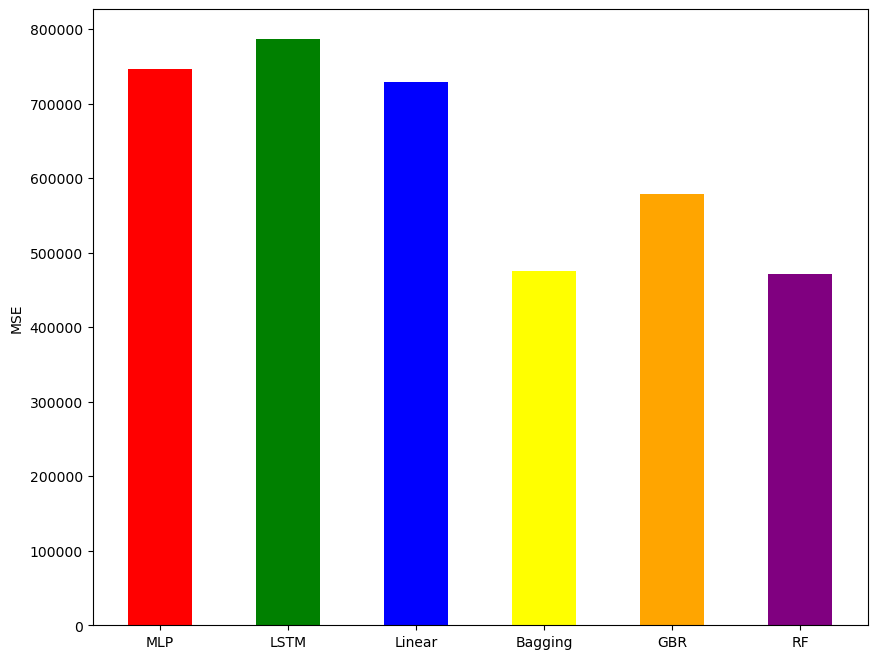

In [32]:
models = ['MLP', 'LSTM', 'Linear', 'Bagging', 'GBR', 'RF']
# create a list of colors for each bar
colors = ['red', 'green', 'blue', 'yellow', 'orange', 'purple']

fig, ax = plt.subplots(figsize=(10, 8))

# plot the bars with the corresponding colors
plt.bar(models, np.array(mse)*10000000, width=0.5, color=colors)
# add a colorbar to show the color scale

plt.ylabel('MSE')
# show the plot
plt.show()

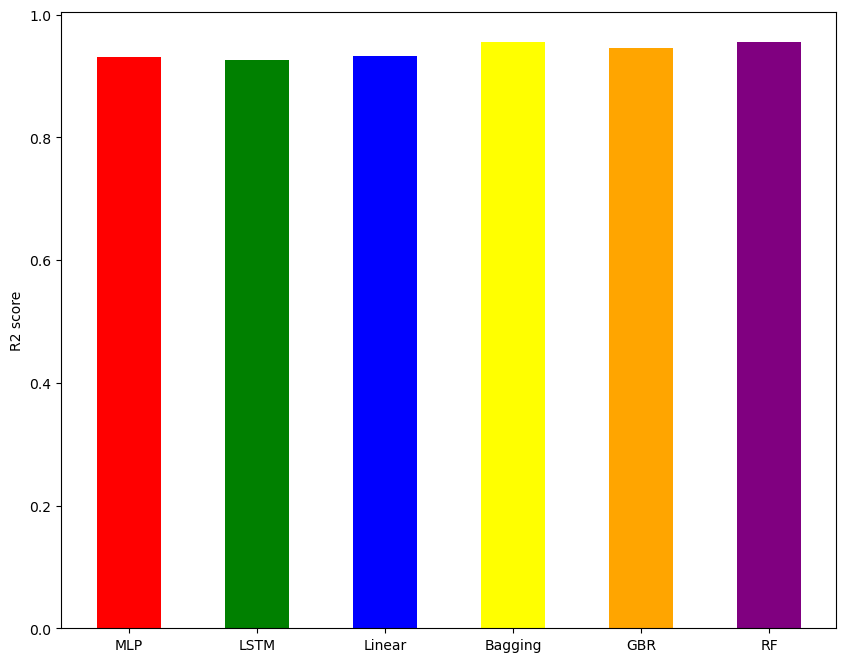

In [33]:
models = ['MLP', 'LSTM', 'Linear', 'Bagging', 'GBR', 'RF']
# create a list of colors for each bar
colors = ['red', 'green', 'blue', 'yellow', 'orange', 'purple']

fig, ax = plt.subplots(figsize=(10, 8))

# plot the bars with the corresponding colors
plt.bar(models, r2score, width=0.5, color=colors)
# add a colorbar to show the color scale

plt.ylabel('R2 score')
# show the plot
plt.show()

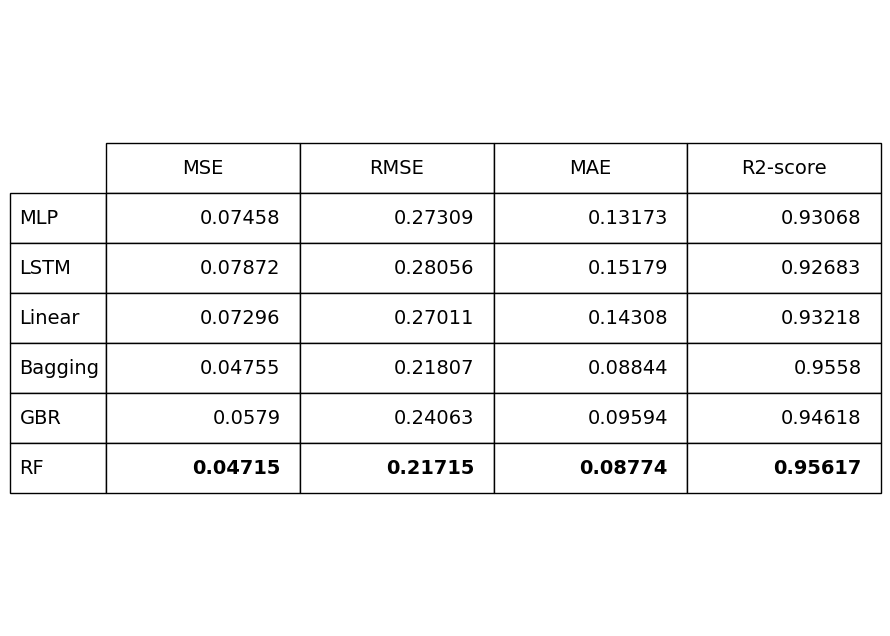

In [34]:
from matplotlib.font_manager import FontProperties

fig, ax = plt.subplots(figsize=(10, 8))
metrics = ['MSE', 'RMSE', 'MAE', 'R2-score']
all_value_metrics = np.array([mse, rmse, mae, r2score])
all_value_metrics = all_value_metrics.T
# plot a table with the metrics as columns and model as rows
table = plt.table(cellText=np.round(all_value_metrics, 5), rowLabels=models, colLabels=metrics, loc='center')
#i want to set in bolds some number
for i in range(len(all_value_metrics)):
  for j in range(len(all_value_metrics[0])):
    if all_value_metrics[i][j] == np.min(all_value_metrics[:, j]) and j != 3:
      table[(i+1, j)].set_text_props(fontproperties=FontProperties(weight='bold'))
    elif all_value_metrics[i][j] == np.max(all_value_metrics[:, j]) and j == 3:
      table[(i+1, j)].set_text_props(fontproperties=FontProperties(weight='bold'))


table.set_fontsize(14)
table.scale(1, 3)
ax.axis('off')
plt.show()